In [1]:
from captum.attr import IntegratedGradients
import deepsudoku
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import deepsudoku.reinforcement_learning
from deepsudoku.reinforcement_learning.ensemble import *
from deepsudoku.reinforcement_learning import agents
import random
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

random.seed(0)

os.chdir(deepsudoku.REPO_PATH)

from nonestop.agents import *

/home/felix/anaconda3/envs/sudoku_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


In [2]:
agent = agents.BestConvModel(True, "cuda").cuda()
agent.load_state_dict(torch.load("nonestop/ckpt/Sudoku-nostop0__AnealLRLonger__1__1693545846/58578944.pth")["model_state_dict"])

<All keys matched successfully>

In [3]:
obs = np.random.randint(0,10,(2,9,9))

agent(obs, get_action = "unraveled")

tensor(0.0802, device='cuda:0')
torch.Size([2])


(array([0, 0]), array([7, 3]), array([0, 0]))

In [4]:

class SoftMaxWrapper(torch.nn.Module):
    
    def __init__(self, agent):
        super().__init__()
        
        self.softmax = nn.Softmax(dim=1)
        self.agent = agent
        
            
    def forward(self, obs, original_image = None):
        
        log_probs = self.agent.actor(obs.permute(0, 3, 2, 1)).permute(0, 3, 2, 1).reshape(-1, 9 ** 3)
        
        if original_image:     
            
            
            self.action_mask = self.agent.get_action_mask(torch.tensor(original_image)[None,:]).cuda()
            log_probs = torch.where(self.action_mask, log_probs, torch.tensor(-1e8).to(log_probs.device)).reshape(-1, 81, 9)
        
        log_probs = log_probs.reshape(-1, 81, 9)
        
        return self.softmax(log_probs).reshape(-1,  9 **3)

    
def get_valid_oberservation_action_pair(env, agent):
    
    obs, action, raveled, original_image = None, None, None, None

    while True:
        original_image, _ = env.reset()

        obs = torch.tensor(original_image).to("cuda")[None,:]

        raveled = agent.get_greedy_action(obs)[0].cpu().numpy()

        action = np.unravel_index(raveled, (9,9,9))

        reward = env.step(action)[1]

        if reward == 1:
            break
    
    return obs, action, raveled, original_image, 


def calculate_integrated_gradients(agent, obs, raveled):

    if not torch.is_tensor(obs):
        
        obs = torch.tensor(obs)
        
    if obs.shape[0] != 1:
        
        obs = torch.unsqueeze(obs, 0)
    
    assert obs.shape == (1,9,9)

    wrapper = SoftMaxWrapper(agent).cuda().float()

    obs = torch.nn.functional.one_hot(obs.to(torch.int64), 10)
    obs = obs.float()

    ig = IntegratedGradients(wrapper)
    attributions, approximation_error = ig.attribute(obs, target = torch.tensor([int(raveled)]),
                                        return_convergence_delta=True, 
                                        )

    atribution = attributions.cpu().numpy().squeeze().sum(-1)

    atribution = np.maximum(atribution, 0)
    return atribution


def farm_and_viz_integrated_gradients(env,agent):

    obs, action, raveled, original_image = get_valid_oberservation_action_pair(env, agent)
        
    atribution = calculate_integrated_gradients(agent, obs, raveled)

    fig = plt.figure(figsize=(6,6 ), dpi = 100)

    field = original_image

    plt.imshow(atribution, "Blues")

    plt.axis("off")
    # Draw grid lines
    for i in range(10):
        if i % 3 == 0:
            plt.vlines(i - 0.5, -0.5, 8.5, colors="black", linewidth=2)
            plt.hlines(i - 0.5, -0.5, 8.5, colors="black", linewidth=2)
        else:
            plt.vlines(i - 0.5, -0.5, 8.5, colors="black", linewidth=1)
            plt.hlines(i - 0.5, -0.5, 8.5, colors="black", linewidth=1)

    # now plot the numbers of field
    for i in range(9):
        for j in range(9):
            if field[i, j] != 0:
                plt.text(
                    j,
                    i,
                    str(field[i, j]),
                    ha="center",
                    va="center",
                    color="black",
                    fontsize=16,
                )

            if (i,j) == action[:2]:
                
                plt.text(
                    j,
                    i,
                    str(action[-1] + 1),
                    ha="center",
                    va="center",
                    color="maroon",
                    fontsize=16,
                )

    return fig



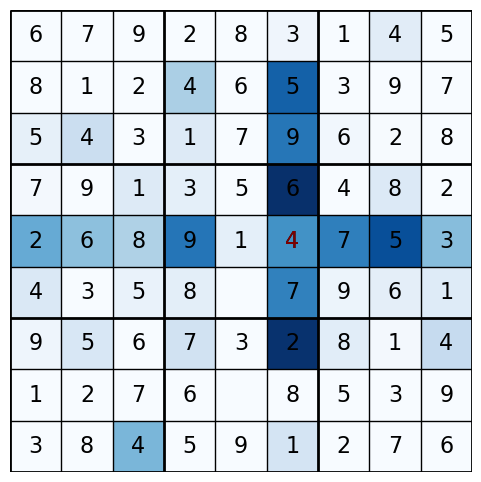

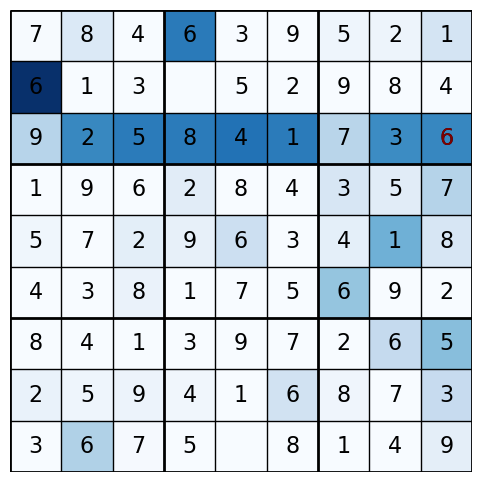

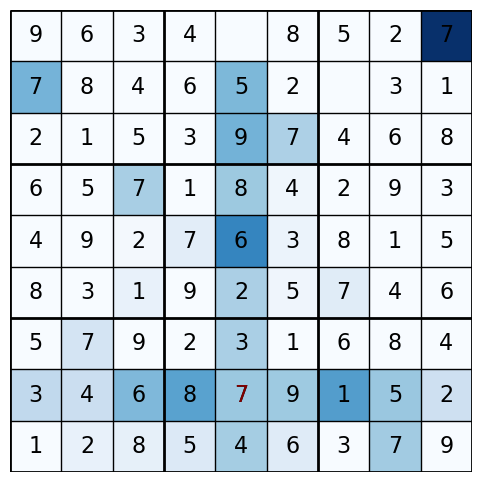

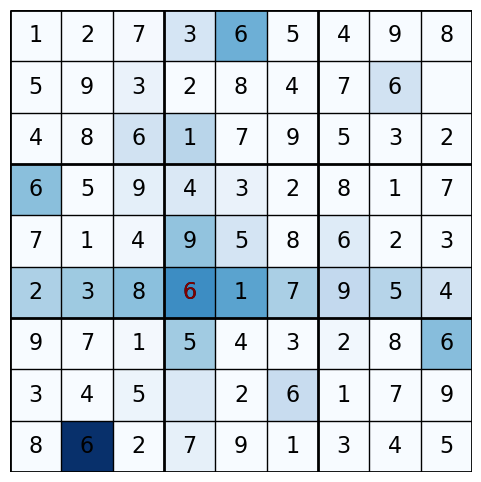

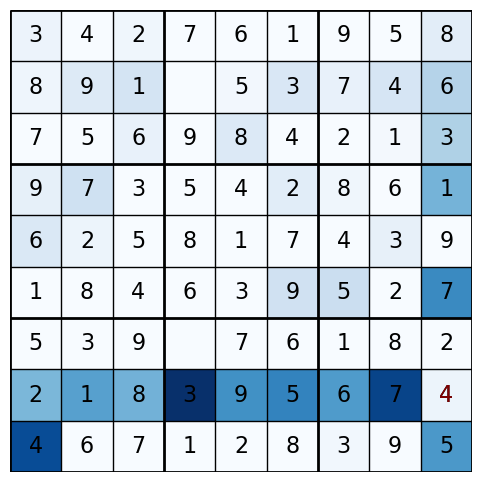

In [14]:
env = gym.make("Sudoku-nostop0", upper_bound_missing_digist = 3)

for _ in range(5):

    fig = farm_and_viz_integrated_gradients(env,agent)
    plt.show()

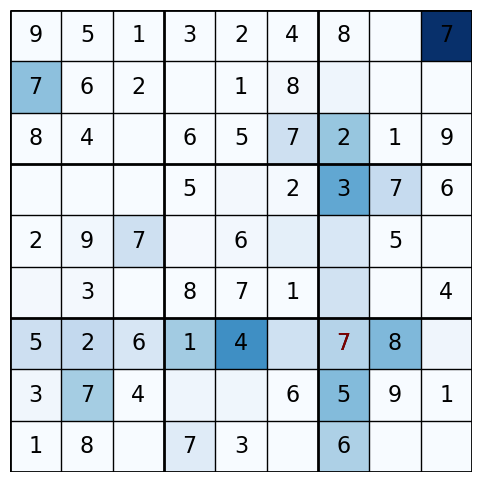

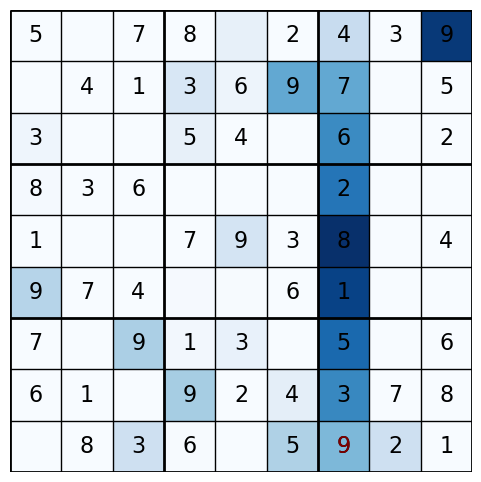

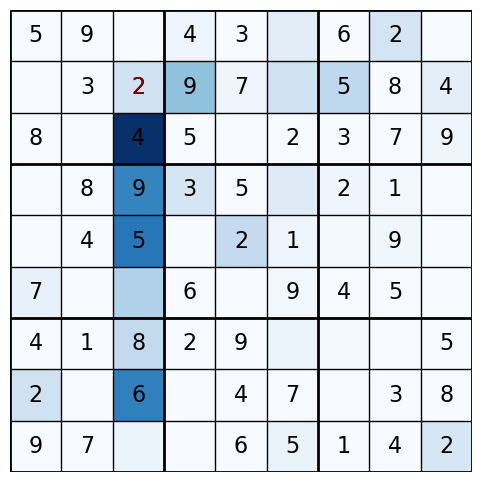

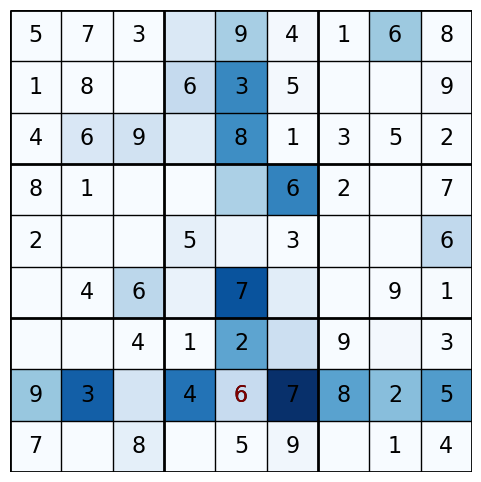

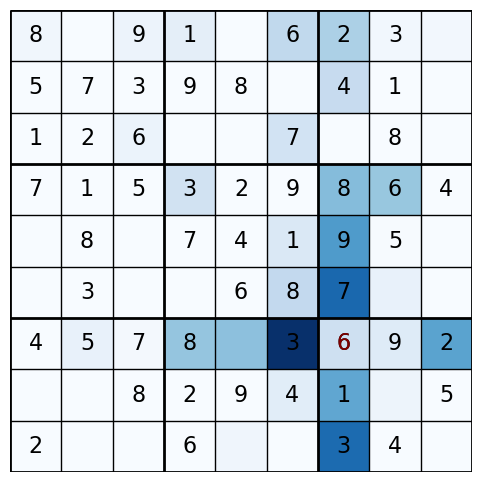

In [15]:
env = gym.make("Sudoku-nostop0",)

for _ in range(5):

    fig = farm_and_viz_integrated_gradients(env,agent)
    plt.show()